In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
import json
from scipy.optimize import linear_sum_assignment

sns.set_theme('notebook')


In [61]:
# Load data from data.json
with open('input/wikics/data.json', 'r') as f:
    data = json.load(f)

# Extract test data
test_mask = np.array(data['test_mask'])
features = np.array(data['features'])
labels = np.array(data['labels'])

# Apply test mask
features = features[test_mask]
labels = labels[test_mask]

print(f"Dataset shape: {features.shape}")
print(f"Number of unique labels: {len(np.unique(labels))}")
print(f"Label distribution: {np.bincount(labels)}")


Dataset shape: (5847, 300)
Number of unique labels: 10
Label distribution: [ 147  333 1076  966 1339  390  206  432  246  712]


In [62]:
# Define clustering algorithms with customizable parameters
clustering_algorithms = {
    'KMeans_30': KMeans(n_clusters=30, random_state=42),
    'KMeans_20': KMeans(n_clusters=20, random_state=42),
    'GMM_10': GaussianMixture(n_components=10, random_state=42),
    'GMM_20': GaussianMixture(n_components=20, random_state=42),
    'DBSCAN_eps0.5': DBSCAN(eps=0.5, min_samples=5),
    'DBSCAN_eps1.0': DBSCAN(eps=1.0, min_samples=5),
    'AgglomerativeClustering_10': AgglomerativeClustering(n_clusters=10),
    'AgglomerativeClustering_20': AgglomerativeClustering(n_clusters=20),
    'SpectralClustering_10': SpectralClustering(n_clusters=10, random_state=42),
    'Graph': 'out/2025-05-28_00-42-55/wikics/clusters_alpha_0.7_K_30.npy'
}

def train_clustering_algorithms(features, algorithms_dict):
    """Train multiple clustering algorithms and return results"""
    results = {}
    for name, algorithm in algorithms_dict.items():
        print(f"Training {name}...")

        try:
            if name == 'Graph':
                clusters = np.load(algorithm)
            elif hasattr(algorithm, 'fit_predict'):
                clusters = algorithm.fit_predict(features)
            else:
                algorithm.fit(features)
                clusters = algorithm.predict(features)
            results[name] = clusters
            print(f"  Success: {len(np.unique(clusters))} clusters")
        except Exception as e:
            print(f"  Failed: {e}")
    return results


# ========== Accuracy

In [63]:
def get_cluster_analysis(true_labels, pred_labels):
    """
    Extract cluster analysis data needed for adaptive thresholds
    """
    cluster_label_counts = {}
    unique_clusters = np.unique(pred_labels)

    for cluster in unique_clusters:
        cluster_mask = pred_labels == cluster
        cluster_true_labels = true_labels[cluster_mask]
        unique, counts = np.unique(cluster_true_labels, return_counts=True)
        cluster_label_counts[cluster] = dict(zip(unique, counts))

    unique, counts = np.unique(pred_labels, return_counts=True)
    cluster_sizes = dict(zip(unique, counts))

    return cluster_label_counts, cluster_sizes

In [64]:
def calculate_clustering_accuracy(true_labels, pred_labels):
    """
    Calculate clustering accuracy using optimal mapping between clusters and true labels.
    Each cluster gets assigned to the true label that appears most frequently in that cluster.
    """
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)

    cluster_label_counts, cluster_sizes = get_cluster_analysis(true_labels, pred_labels)

    cluster_to_label_mapping = {}

    sorted_clusters = sorted(cluster_sizes.items(), key=lambda x: x[1], reverse=True)
    for cluster, size in sorted_clusters:
        if cluster in cluster_label_counts:
            # Find the most frequent true label
            sorted_labels = sorted(cluster_label_counts[cluster].items(),
                                   key=lambda x: x[1], reverse=True)

            cluster_to_label_mapping[cluster] = sorted_labels[0][0]

    correct_predictions = 0
    total_predictions = len(pred_labels)

    for i in range(total_predictions):
        predicted_cluster = pred_labels[i]
        true_label = true_labels[i]

        if predicted_cluster in cluster_to_label_mapping:
            mapped_label = cluster_to_label_mapping[predicted_cluster]
            if mapped_label == true_label:
                correct_predictions += 1

    accuracy = correct_predictions / total_predictions

    return accuracy, cluster_to_label_mapping


# ==========

In [65]:
print("Training new clustering algorithms...")
clustering_results = train_clustering_algorithms(features, clustering_algorithms)

Training new clustering algorithms...
Training KMeans_10...
  Success: 10 clusters
Training KMeans_20...
  Success: 20 clusters
Training GMM_10...
  Success: 10 clusters
Training GMM_20...
  Success: 20 clusters
Training DBSCAN_eps0.5...
  Success: 3 clusters
Training DBSCAN_eps1.0...
  Success: 2 clusters
Training AgglomerativeClustering_10...
  Success: 10 clusters
Training AgglomerativeClustering_20...
  Success: 20 clusters
Training SpectralClustering_10...
  Success: 10 clusters
Training Graph...
  Success: 30 clusters


In [66]:
def evaluate_clustering_results(features, true_labels, clustering_results):
    """Evaluate all clustering results with multiple metrics"""
    evaluation_metrics = {}
    
    for name, pred_labels in clustering_results.items():
        if len(np.unique(pred_labels)) > 1:
            try:
                accuracy, cluster_to_label_mapping = calculate_clustering_accuracy(true_labels, pred_labels)
                ari = adjusted_rand_score(true_labels, pred_labels)
                nmi = normalized_mutual_info_score(true_labels, pred_labels)
                silhouette = silhouette_score(features, pred_labels)
                
                evaluation_metrics[name] = {
                    'Accuracy': accuracy,
                    'ARI': ari,
                    'NMI': nmi,
                    'Silhouette': silhouette,
                    'N_Clusters': len(np.unique(pred_labels))
                }
                
                print(f"{name}:")
                print(f"  Accuracy: {accuracy:.4f}")
                print(f"  ARI: {ari:.4f}")
                print(f"  NMI: {nmi:.4f}")
                print(f"  Silhouette: {silhouette:.4f}")
                print(f"  Clusters: {len(np.unique(pred_labels))}")
                print()
            except Exception as e:
                print(f"{name}: Error in evaluation - {e}")
        else:
            print(f"{name}: Single cluster - skipping evaluation")
            print()
    
    return evaluation_metrics

# Evaluate all results
print("\nEvaluating clustering results...")
evaluation_metrics = evaluate_clustering_results(features, labels, clustering_results)



Evaluating clustering results...
KMeans_10:
  Accuracy: 0.4702
  ARI: 0.1477
  NMI: 0.2531
  Silhouette: 0.0744
  Clusters: 10

KMeans_20:
  Accuracy: 0.5312
  ARI: 0.1284
  NMI: 0.2862
  Silhouette: 0.0623
  Clusters: 20

GMM_10:
  Accuracy: 0.4678
  ARI: 0.1464
  NMI: 0.2532
  Silhouette: 0.0728
  Clusters: 10

GMM_20:
  Accuracy: 0.5312
  ARI: 0.1284
  NMI: 0.2861
  Silhouette: 0.0622
  Clusters: 20

DBSCAN_eps0.5:
  Accuracy: 0.2304
  ARI: -0.0003
  NMI: 0.0023
  Silhouette: -0.2320
  Clusters: 3

DBSCAN_eps1.0:
  Accuracy: 0.2290
  ARI: 0.0101
  NMI: 0.0051
  Silhouette: 0.1099
  Clusters: 2

AgglomerativeClustering_10:
  Accuracy: 0.4549
  ARI: 0.1318
  NMI: 0.2372
  Silhouette: 0.0540
  Clusters: 10

AgglomerativeClustering_20:
  Accuracy: 0.5184
  ARI: 0.1255
  NMI: 0.2842
  Silhouette: 0.0379
  Clusters: 20

SpectralClustering_10:
  Accuracy: 0.4838
  ARI: 0.1516
  NMI: 0.2401
  Silhouette: 0.0782
  Clusters: 10

Graph:
  Accuracy: 0.7941
  ARI: 0.3588
  NMI: 0.6327
  Silhoue

Performing PCA...


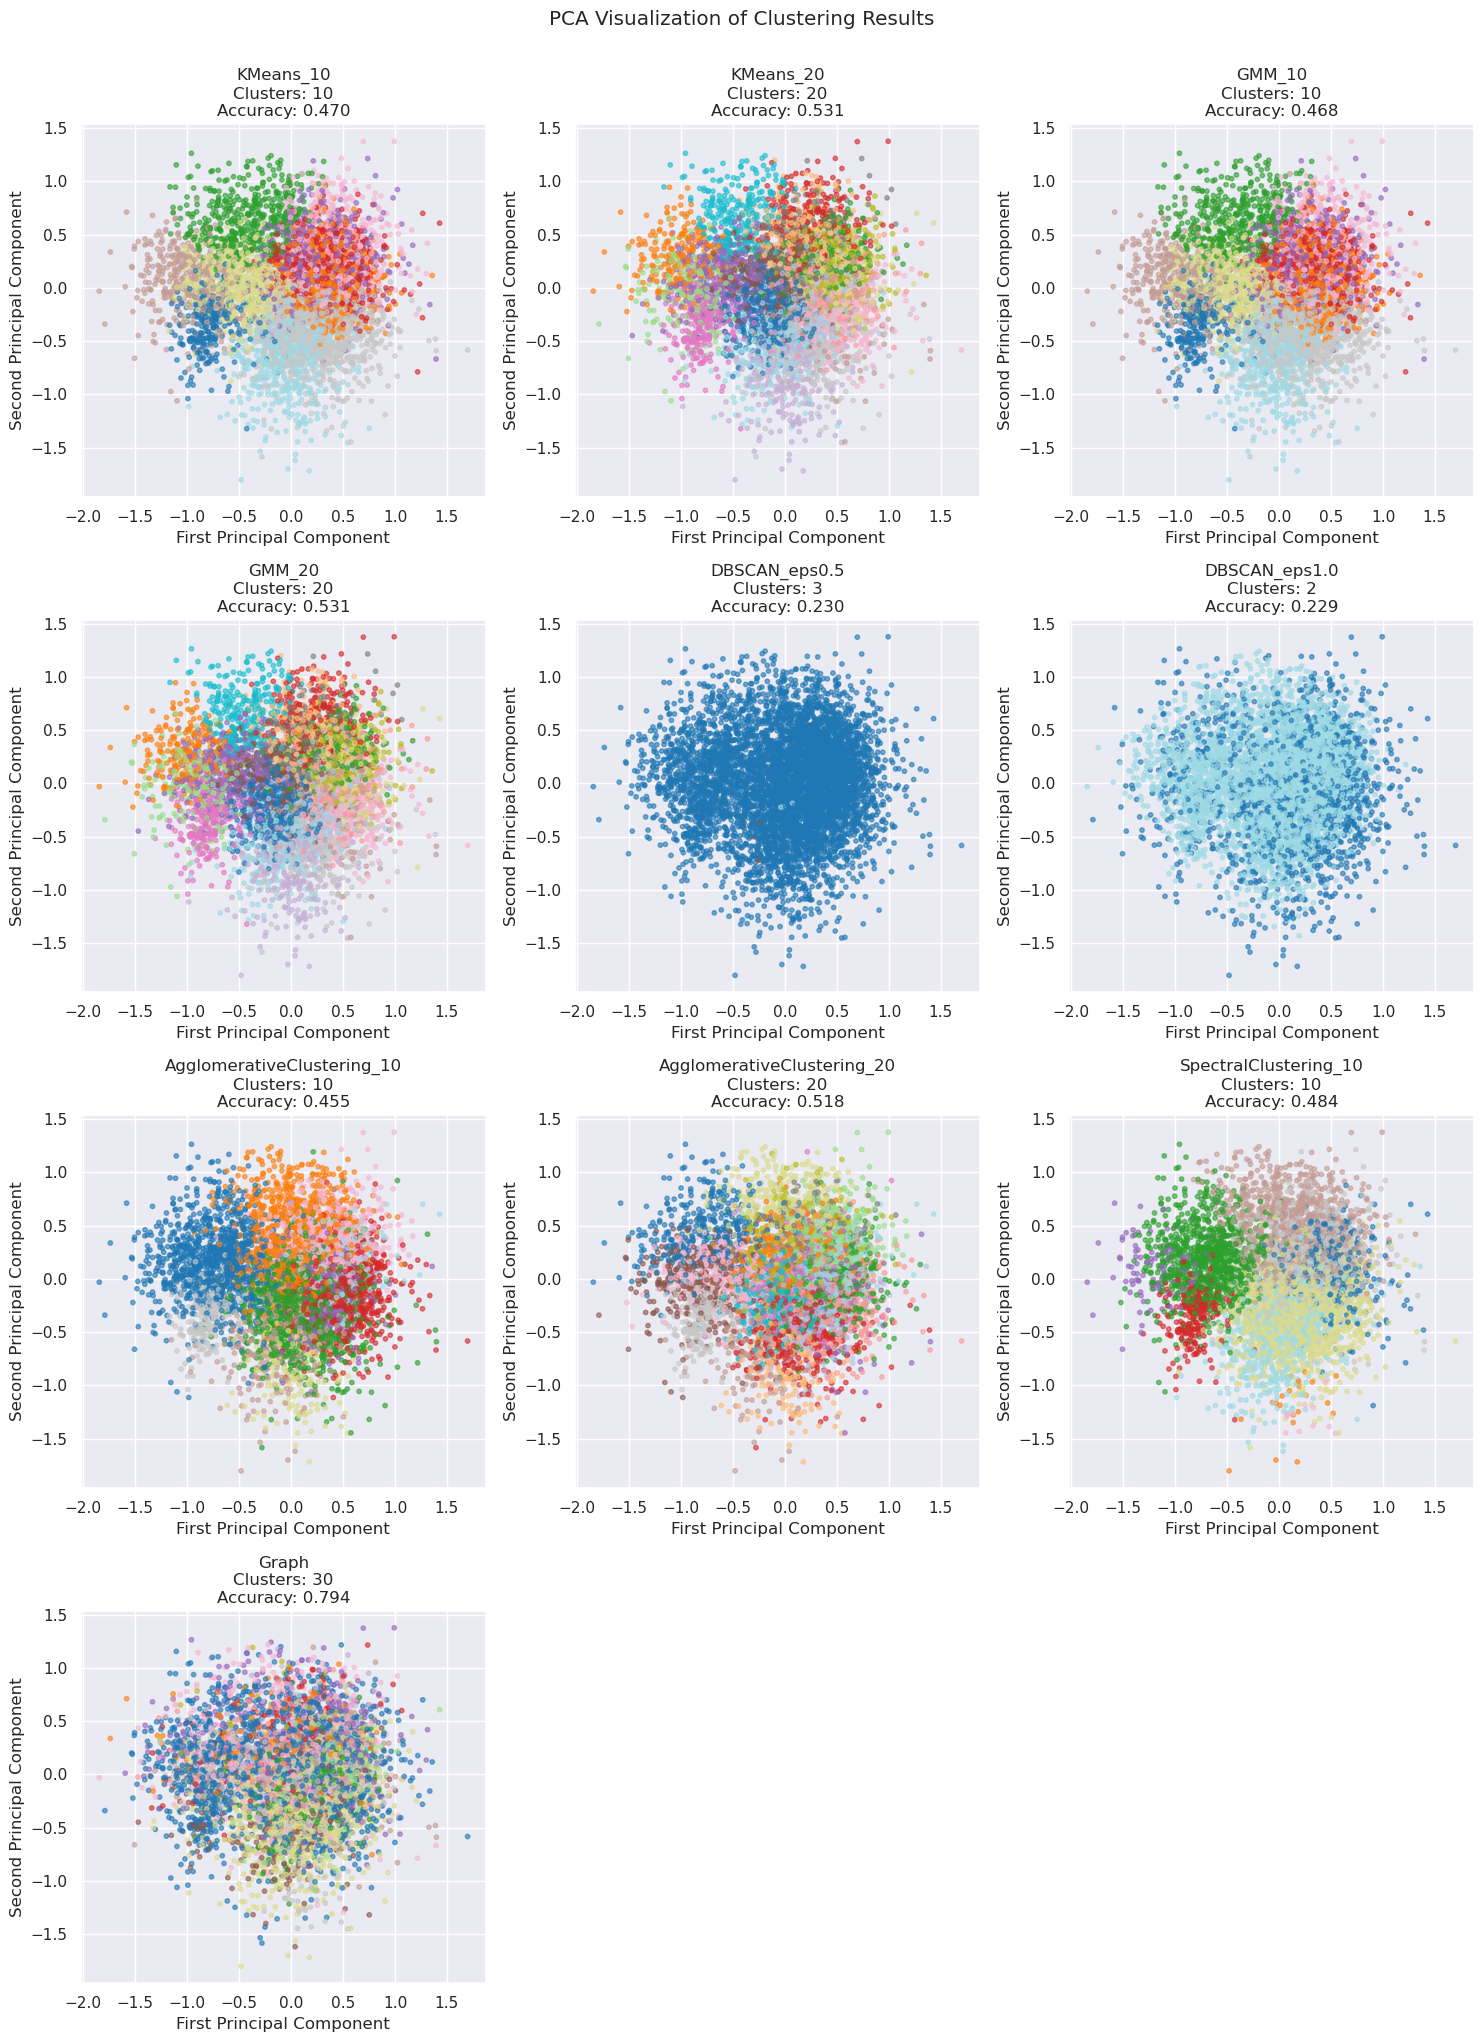

PCA explained variance ratio: [0.14671498 0.11182166]


In [67]:
# PCA Visualization
print("Performing PCA...")
pca = PCA(n_components=2, random_state=42)
features_pca = pca.fit_transform(features)

n_algorithms = len(clustering_results)
cols = 3
rows = (n_algorithms + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
if rows == 1:
    axes = axes.reshape(1, -1)

for i, (name, clusters) in enumerate(clustering_results.items()):
    row, col = i // cols, i % cols
    
    # Create scatter plot
    scatter = axes[row, col].scatter(features_pca[:, 0], features_pca[:, 1], 
                                   c=clusters, cmap='tab20', alpha=0.6, s=10)
    
    # Add title with metrics if available
    title = f'{name}\nClusters: {len(np.unique(clusters))}'
    if name in evaluation_metrics:
        acc = evaluation_metrics[name]['Accuracy']
        title += f'\nAccuracy: {acc:.3f}'
    
    axes[row, col].set_title(title)
    axes[row, col].set_xlabel('First Principal Component')
    axes[row, col].set_ylabel('Second Principal Component')

# Hide unused subplots
for i in range(n_algorithms, rows * cols):
    row, col = i // cols, i % cols
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.suptitle('PCA Visualization of Clustering Results', y=1.02)
plt.show()

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")


Performing t-SNE...


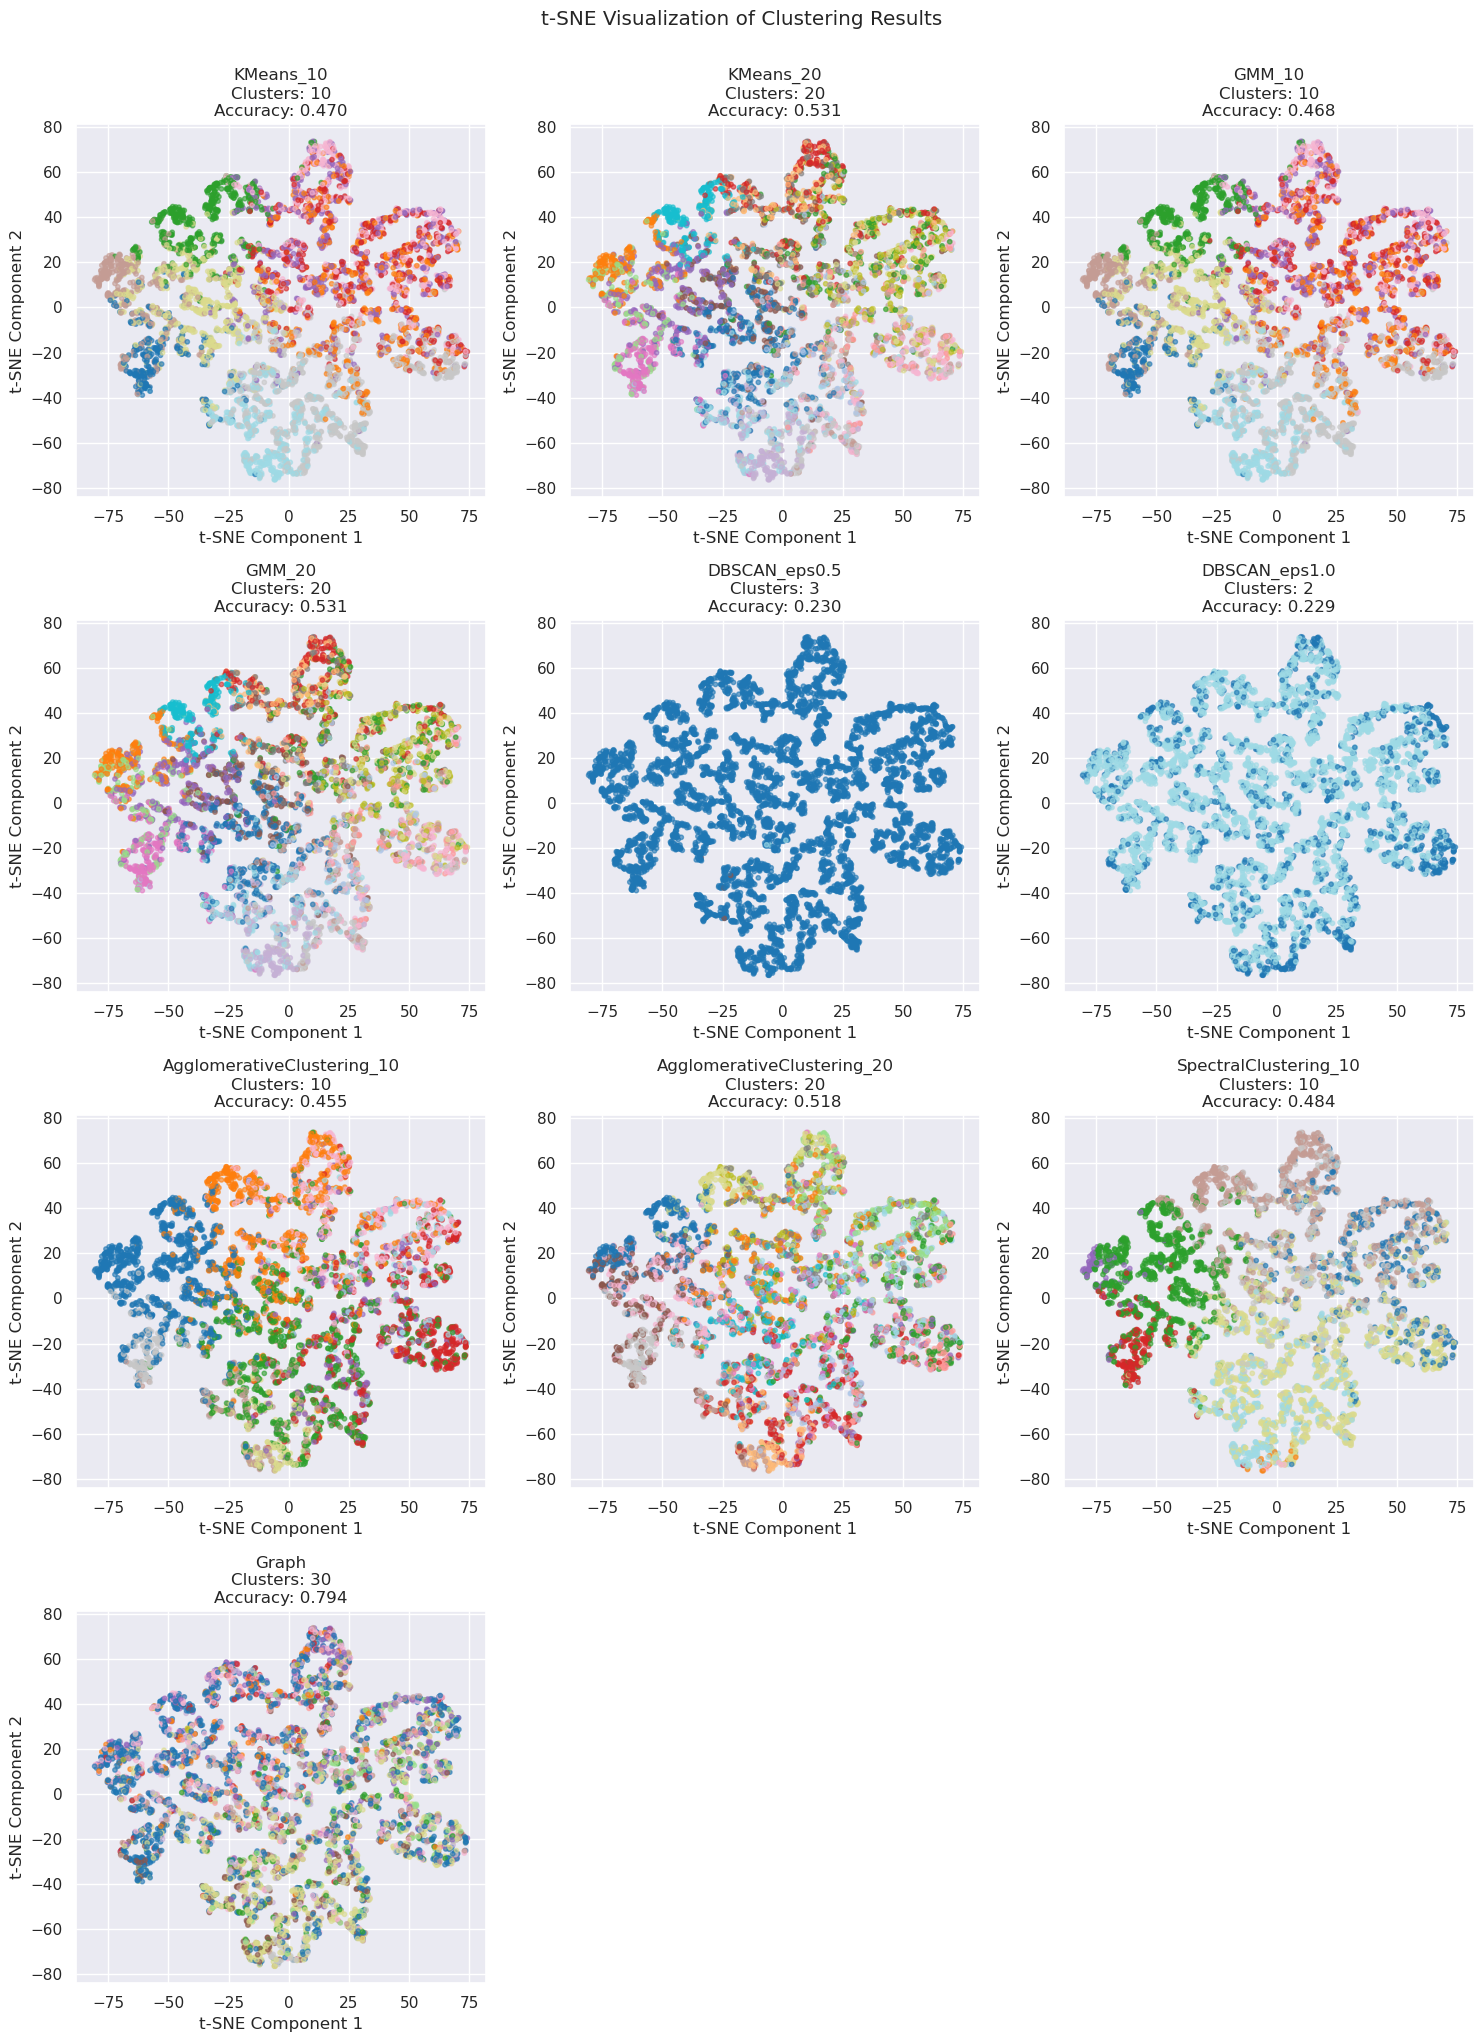

In [68]:
# t-SNE Visualization
print("Performing t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_tsne = tsne.fit_transform(features_pca)  # Use PCA results for speed

fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
if rows == 1:
    axes = axes.reshape(1, -1)

for i, (name, clusters) in enumerate(clustering_results.items()):
    row, col = i // cols, i % cols
    
    # Create scatter plot
    scatter = axes[row, col].scatter(features_tsne[:, 0], features_tsne[:, 1], 
                                   c=clusters, cmap='tab20', alpha=0.6, s=10)
    
    # Add title with metrics if available
    title = f'{name}\nClusters: {len(np.unique(clusters))}'
    if name in evaluation_metrics:
        acc = evaluation_metrics[name]['Accuracy']
        title += f'\nAccuracy: {acc:.3f}'
    
    axes[row, col].set_title(title)
    axes[row, col].set_xlabel('t-SNE Component 1')
    axes[row, col].set_ylabel('t-SNE Component 2')

# Hide unused subplots
for i in range(n_algorithms, rows * cols):
    row, col = i // cols, i % cols
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.suptitle('t-SNE Visualization of Clustering Results', y=1.02)
plt.show()


CLUSTERING RESULTS SUMMARY
                            Accuracy     ARI     NMI  Silhouette  N_Clusters
Graph                         0.7941  0.3588  0.6327     -0.1154        30.0
KMeans_20                     0.5312  0.1284  0.2862      0.0623        20.0
GMM_20                        0.5312  0.1284  0.2861      0.0622        20.0
AgglomerativeClustering_20    0.5184  0.1255  0.2842      0.0379        20.0
SpectralClustering_10         0.4838  0.1516  0.2401      0.0782        10.0
KMeans_10                     0.4702  0.1477  0.2531      0.0744        10.0
GMM_10                        0.4678  0.1464  0.2532      0.0728        10.0
AgglomerativeClustering_10    0.4549  0.1318  0.2372      0.0540        10.0
DBSCAN_eps0.5                 0.2304 -0.0003  0.0023     -0.2320         3.0
DBSCAN_eps1.0                 0.2290  0.0101  0.0051      0.1099         2.0


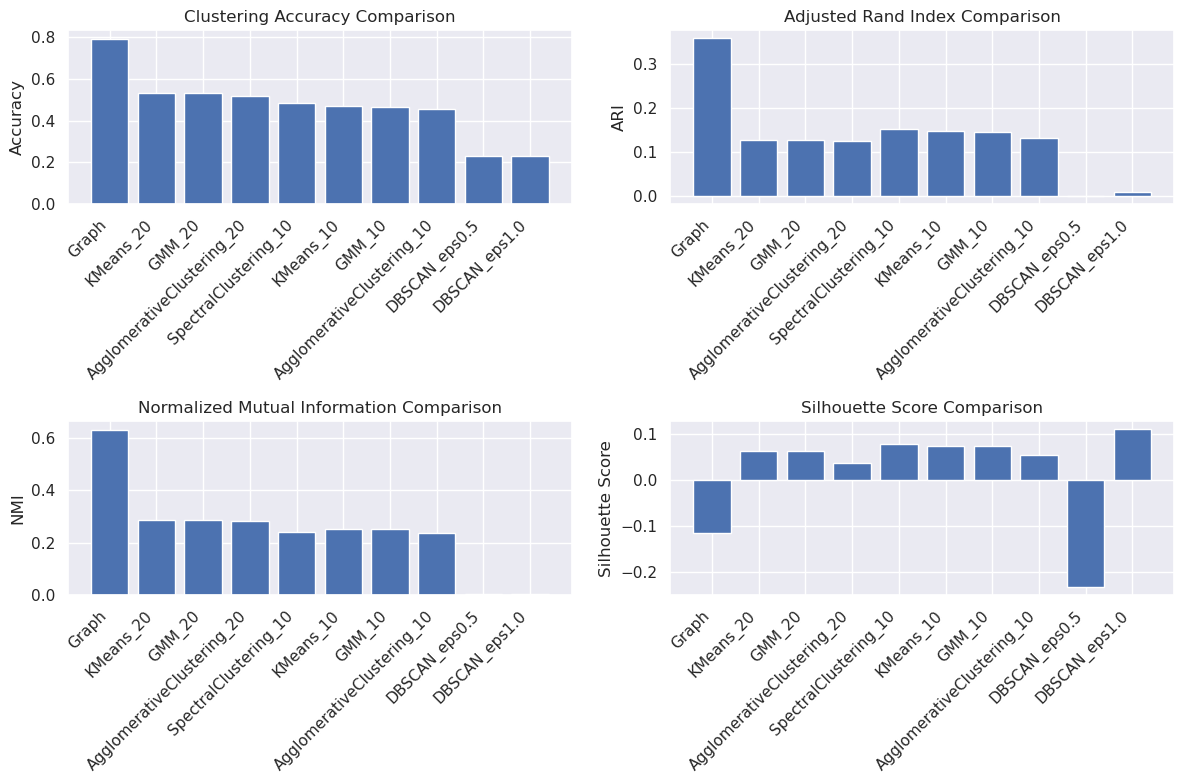


Best performing algorithm: Graph
Best accuracy: 0.7941


In [69]:
summary_df = pd.DataFrame(evaluation_metrics).T
summary_df = summary_df.sort_values('Accuracy', ascending=False)

print("CLUSTERING RESULTS SUMMARY")
print("=" * 50)
print(summary_df.round(4))

# Plot comparison
plt.figure(figsize=(12, 8))

# Accuracy comparison
plt.subplot(2, 2, 1)
plt.bar(range(len(summary_df)), summary_df['Accuracy'])
plt.xticks(range(len(summary_df)), summary_df.index, rotation=45, ha='right')
plt.title('Clustering Accuracy Comparison')
plt.ylabel('Accuracy')

# ARI comparison
plt.subplot(2, 2, 2)
plt.bar(range(len(summary_df)), summary_df['ARI'])
plt.xticks(range(len(summary_df)), summary_df.index, rotation=45, ha='right')
plt.title('Adjusted Rand Index Comparison')
plt.ylabel('ARI')

# NMI comparison
plt.subplot(2, 2, 3)
plt.bar(range(len(summary_df)), summary_df['NMI'])
plt.xticks(range(len(summary_df)), summary_df.index, rotation=45, ha='right')
plt.title('Normalized Mutual Information Comparison')
plt.ylabel('NMI')

# Silhouette comparison
plt.subplot(2, 2, 4)
plt.bar(range(len(summary_df)), summary_df['Silhouette'])
plt.xticks(range(len(summary_df)), summary_df.index, rotation=45, ha='right')
plt.title('Silhouette Score Comparison')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Best performing algorithm
best_algorithm = summary_df.index[0]
best_accuracy = summary_df.loc[best_algorithm, 'Accuracy']
print(f"\nBest performing algorithm: {best_algorithm}")
print(f"Best accuracy: {best_accuracy:.4f}")


In [97]:
NUM_ALGOS = 5

# Get top NUM_ALGOS algorithms based on accuracy
summary_df = pd.DataFrame(evaluation_metrics).T
summary_df = summary_df.sort_values('Accuracy', ascending=False)
top_algorithms = summary_df.head(NUM_ALGOS).index.tolist()

print(f"Top {NUM_ALGOS} algorithms selected for majority voting:")
for i, algo in enumerate(top_algorithms, 1):
    acc = summary_df.loc[algo, 'Accuracy']
    print(f"  {i}. {algo}: {acc:.4f}")

Top 5 algorithms selected for majority voting:
  1. Graph: 0.7941
  2. KMeans_20: 0.5312
  3. GMM_20: 0.5312
  4. AgglomerativeClustering_20: 0.5184
  5. SpectralClustering_10: 0.4838


In [98]:
top_predictions_arrays = [np.array(clustering_results[algo_name]) for algo_name in top_algorithms]

In [101]:
n_samples = len(top_predictions_arrays[0])
majority_labels = np.zeros(n_samples, dtype=int)

# For each sample, find the most common prediction across all NUM_ALGOS algorithms
for i in range(n_samples):
    votes = [pred[i] for pred in top_predictions_arrays]
    unique_votes, vote_counts = np.unique(votes, return_counts=True)
    max_votes_idx = np.argmax(vote_counts)
    majority_labels[i] = unique_votes[max_votes_idx]

clustering_results[f'Majority_Voting_Top{NUM_ALGOS}'] = majority_labels

In [102]:
majority_accuracy, majority_mapping = calculate_clustering_accuracy(labels, majority_labels)
majority_ari = adjusted_rand_score(labels, majority_labels)
majority_nmi = normalized_mutual_info_score(labels, majority_labels)
majority_silhouette = silhouette_score(features, majority_labels)

print(f"\nMajority Voting Results:")
print(f"  Accuracy: {majority_accuracy:.4f}")
print(f"  ARI: {majority_ari:.4f}")
print(f"  NMI: {majority_nmi:.4f}")
print(f"  Silhouette: {majority_silhouette:.4f}")
print(f"  Clusters: {len(np.unique(majority_labels))}")

# Compare with individual algorithms
print(f"\nComparison with individual algorithms:")
for algo in top_algorithms:
    individual_acc = evaluation_metrics[algo]['Accuracy']
    improvement = majority_accuracy - individual_acc
    print(f"  vs {algo}: {improvement:+.4f} (majority: {majority_accuracy:.4f}, individual: {individual_acc:.4f})")

# Add to evaluation metrics
evaluation_metrics['Majority_Voting_Top'] = {
    'Accuracy': majority_accuracy,
    'ARI': majority_ari,
    'NMI': majority_nmi,
    'Silhouette': majority_silhouette,
    'N_Clusters': len(np.unique(majority_labels))
}


Majority Voting Results:
  Accuracy: 0.5103
  ARI: 0.1132
  NMI: 0.2661
  Silhouette: 0.0422
  Clusters: 20

Comparison with individual algorithms:
  vs Graph: -0.2837 (majority: 0.5103, individual: 0.7941)
  vs KMeans_20: -0.0209 (majority: 0.5103, individual: 0.5312)
  vs GMM_20: -0.0209 (majority: 0.5103, individual: 0.5312)
  vs AgglomerativeClustering_20: -0.0080 (majority: 0.5103, individual: 0.5184)
  vs SpectralClustering_10: +0.0265 (majority: 0.5103, individual: 0.4838)


In [103]:
print("\nCreating visualization for majority voting...")


Creating visualization for majority voting...


Text(0, 0.5, 'Second Principal Component')

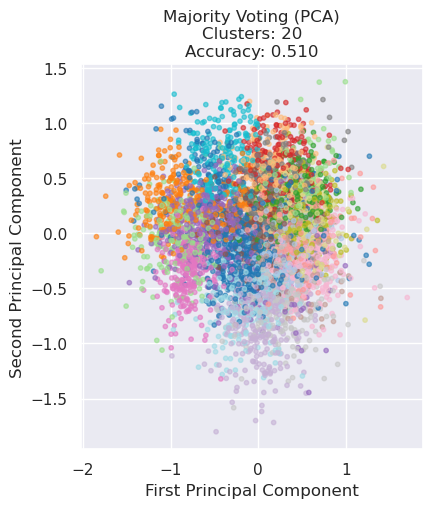

In [104]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
scatter1 = plt.scatter(features_pca[:, 0], features_pca[:, 1],
                     c=majority_labels, cmap='tab20', alpha=0.6, s=10)
plt.title(f'Majority Voting (PCA)\nClusters: {len(np.unique(majority_labels))}\nAccuracy: {majority_accuracy:.3f}')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

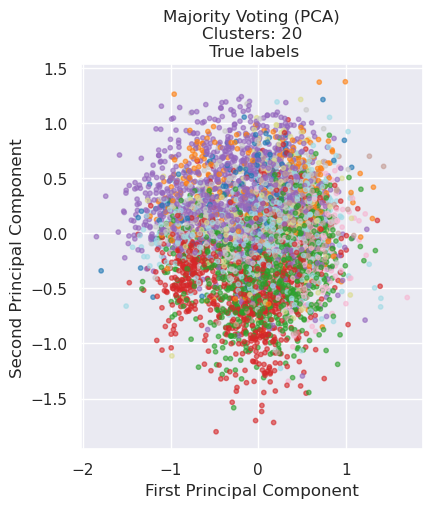

In [105]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
scatter3 = plt.scatter(features_pca[:, 0], features_pca[:, 1],
                     c=labels, cmap='tab20', alpha=0.6, s=10)
plt.title(f'Majority Voting (PCA)\nClusters: {len(np.unique(majority_labels))}\n True labels')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

plt.show()

Text(0, 0.5, 't-SNE Component 2')

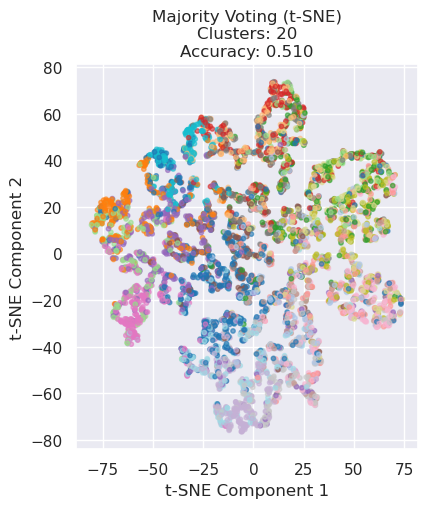

In [106]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
scatter2 = plt.scatter(features_tsne[:, 0], features_tsne[:, 1],
                     c=majority_labels, cmap='tab20', alpha=0.6, s=10)
plt.title(f'Majority Voting (t-SNE)\nClusters: {len(np.unique(majority_labels))}\nAccuracy: {majority_accuracy:.3f}')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')


UPDATED CLUSTERING RESULTS SUMMARY (including Majority Voting)
                            Accuracy     ARI     NMI  Silhouette  N_Clusters
Graph                         0.7941  0.3588  0.6327     -0.1154        30.0
GMM_20                        0.5312  0.1284  0.2861      0.0622        20.0
KMeans_20                     0.5312  0.1284  0.2862      0.0623        20.0
AgglomerativeClustering_20    0.5184  0.1255  0.2842      0.0379        20.0
Majority_Voting_Top           0.5103  0.1132  0.2661      0.0422        20.0
SpectralClustering_10         0.4838  0.1516  0.2401      0.0782        10.0
KMeans_10                     0.4702  0.1477  0.2531      0.0744        10.0
GMM_10                        0.4678  0.1464  0.2532      0.0728        10.0
AgglomerativeClustering_10    0.4549  0.1318  0.2372      0.0540        10.0
DBSCAN_eps0.5                 0.2304 -0.0003  0.0023     -0.2320         3.0
DBSCAN_eps1.0                 0.2290  0.0101  0.0051      0.1099         2.0


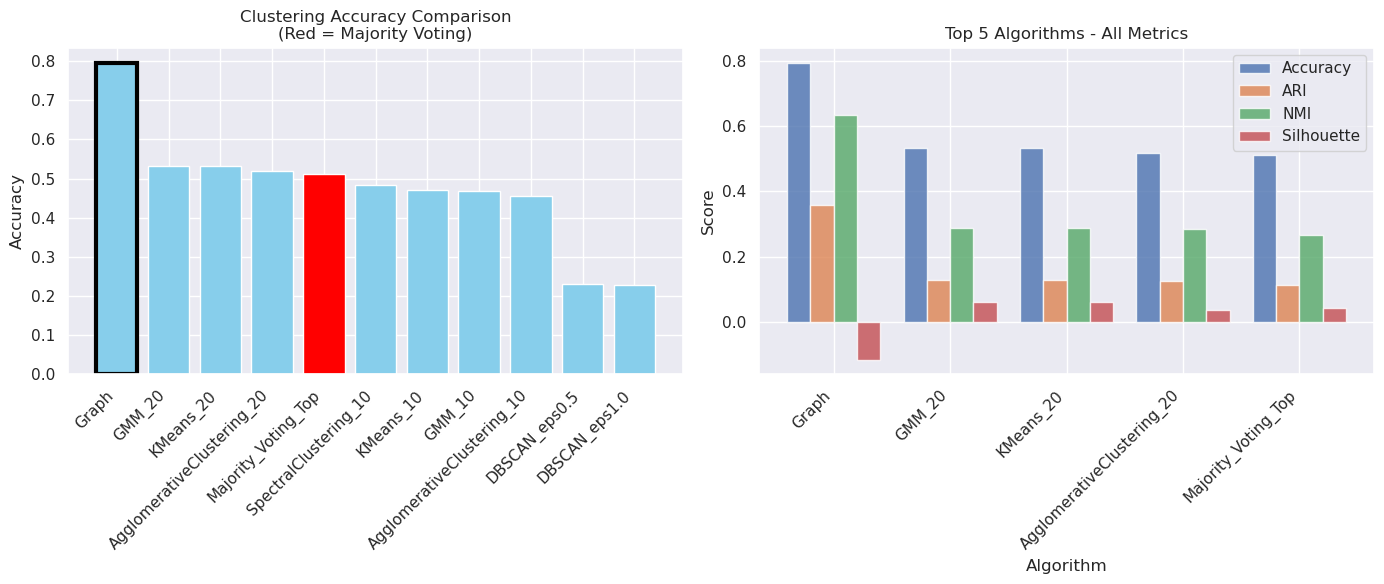


FINAL RESULTS:
Best individual algorithm: Graph with accuracy 0.7941
Majority voting accuracy: 0.5103
❌ Majority voting DECREASED accuracy by 0.2837


In [107]:
updated_summary_df = pd.DataFrame(evaluation_metrics).T
updated_summary_df = updated_summary_df.sort_values('Accuracy', ascending=False)

print("\nUPDATED CLUSTERING RESULTS SUMMARY (including Majority Voting)")
print("=" * 70)
print(updated_summary_df.round(4))

# Final comparison chart
plt.figure(figsize=(14, 6))

# Accuracy comparison including majority voting
plt.subplot(1, 2, 1)
colors = ['red' if 'Majority' in idx else 'skyblue' for idx in updated_summary_df.index]
bars = plt.bar(range(len(updated_summary_df)), updated_summary_df['Accuracy'], color=colors)
plt.xticks(range(len(updated_summary_df)), updated_summary_df.index, rotation=45, ha='right')
plt.title('Clustering Accuracy Comparison\n(Red = Majority Voting)')
plt.ylabel('Accuracy')

# Highlight the best result
best_idx = updated_summary_df['Accuracy'].idxmax()
best_pos = updated_summary_df.index.get_loc(best_idx)
bars[best_pos].set_edgecolor('black')
bars[best_pos].set_linewidth(3)

# All metrics comparison for top algorithms
plt.subplot(1, 2, 2)
top_5_algos = updated_summary_df.head(5)
metrics_to_plot = ['Accuracy', 'ARI', 'NMI', 'Silhouette']
x = np.arange(len(top_5_algos))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + i*width, top_5_algos[metric], width,
           label=metric, alpha=0.8)

plt.xlabel('Algorithm')
plt.ylabel('Score')
plt.title('Top 5 Algorithms - All Metrics')
plt.xticks(x + width*1.5, top_5_algos.index, rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()

# Final results
print(f"\nFINAL RESULTS:")
print(f"Best individual algorithm: {top_algorithms[0]} with accuracy {summary_df.iloc[0]['Accuracy']:.4f}")
print(f"Majority voting accuracy: {majority_accuracy:.4f}")

if majority_accuracy > summary_df.iloc[0]['Accuracy']:
    improvement = majority_accuracy - summary_df.iloc[0]['Accuracy']
    print(f"✅ Majority voting IMPROVED accuracy by {improvement:.4f}")
else:
    decline = summary_df.iloc[0]['Accuracy'] - majority_accuracy
    print(f"❌ Majority voting DECREASED accuracy by {decline:.4f}")